In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler

# Optimizing
from tpot import TPOTClassifier
from sklearn import tree

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\AarPi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
## Getting data ##
learned_data_path = '../clean_learned_EEG/combined_learned.csv'
not_learned_data_path = '../clean_not_learned_EEG/combined_not_learned.csv'

learned_data = pd.read_csv(learned_data_path, header=None)
not_learned_data = pd.read_csv(not_learned_data_path, header=None)

# checking how much data for each category
print(f"original learned shape: {learned_data.shape}")
print(f"original not_learned shape: {not_learned_data.shape}")

# make them equal to remove bias
learned_data = learned_data.sample(frac=1, random_state=42).reset_index(drop=True)
not_learned_data = not_learned_data.sample(frac=1, random_state=42).reset_index(drop=True)

# get length 
learned_length = learned_data.shape[0]
not_learned_length = not_learned_data.shape[0]

new_learned_data = learned_data.drop(index=range(not_learned_length, learned_length))
new_not_learned_data = not_learned_data.drop(index=range(learned_length, not_learned_length))

# print results
print(f"new learned shape: {new_learned_data.shape}")
print(f"new not_learned shape: {not_learned_data.shape}")

original learned shape: (793, 1232)
original not_learned shape: (160, 1232)
new learned shape: (160, 1232)
new not_learned shape: (160, 1232)


In [19]:
# convert pd to a np array for the feature matrix X
X_learned = new_learned_data.values  
X_not_learned = not_learned_data.values

# make the label vector y
'''
to indicate which epochs go to which condition
y vector label should be as long as x matrix is long

zeros = learned
ones = not learned
'''
y_learned = np.zeros(X_learned.shape[0])
y_not_learned = np.ones(X_not_learned.shape[0])

# combine the data and labels
# learned + not learned 
# learned labels + not learned labels
X = np.concatenate([X_learned, X_not_learned], axis=0)
y = np.concatenate([y_learned, y_not_learned], axis=0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


**Default Model**

In [22]:
## MODEL ##

# Training
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train, y_train)

# test it
y_pred = default_rf.predict(X_test)

# get the accuracy
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


### Put the model in a pickle
import pickle

with open('my_model.pkl', 'wb') as file:
    pickle.dump(default_rf, file)

Confusion Matrix: 
 [[23 11]
 [13 17]]
Accuracy: 0.625


**Optimized Model**


In [19]:
# create a list of parameters to modify and change
param_dist = {'n_estimators': randint(200,800),
              'max_depth': randint(1,20),
              'random_state' : randint(10,50)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=200, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A1EB33DF50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A1F27F18D0>,
                                        'random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A1EB3DF490>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Save the best parameters here:
# Best hyperparameters: {'max_depth': 14, 'n_estimators': 306, 'random_state': 30} accuracy: 0.671875


Best hyperparameters: {'max_depth': 17, 'n_estimators': 493, 'random_state': 46}


Confusion Matrix: 
 [[19  8]
 [16 21]]
Accuracy: 0.625


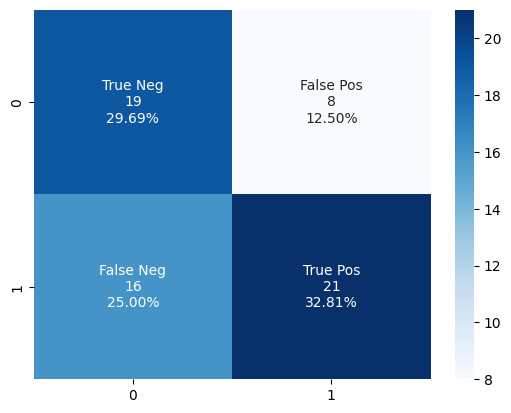

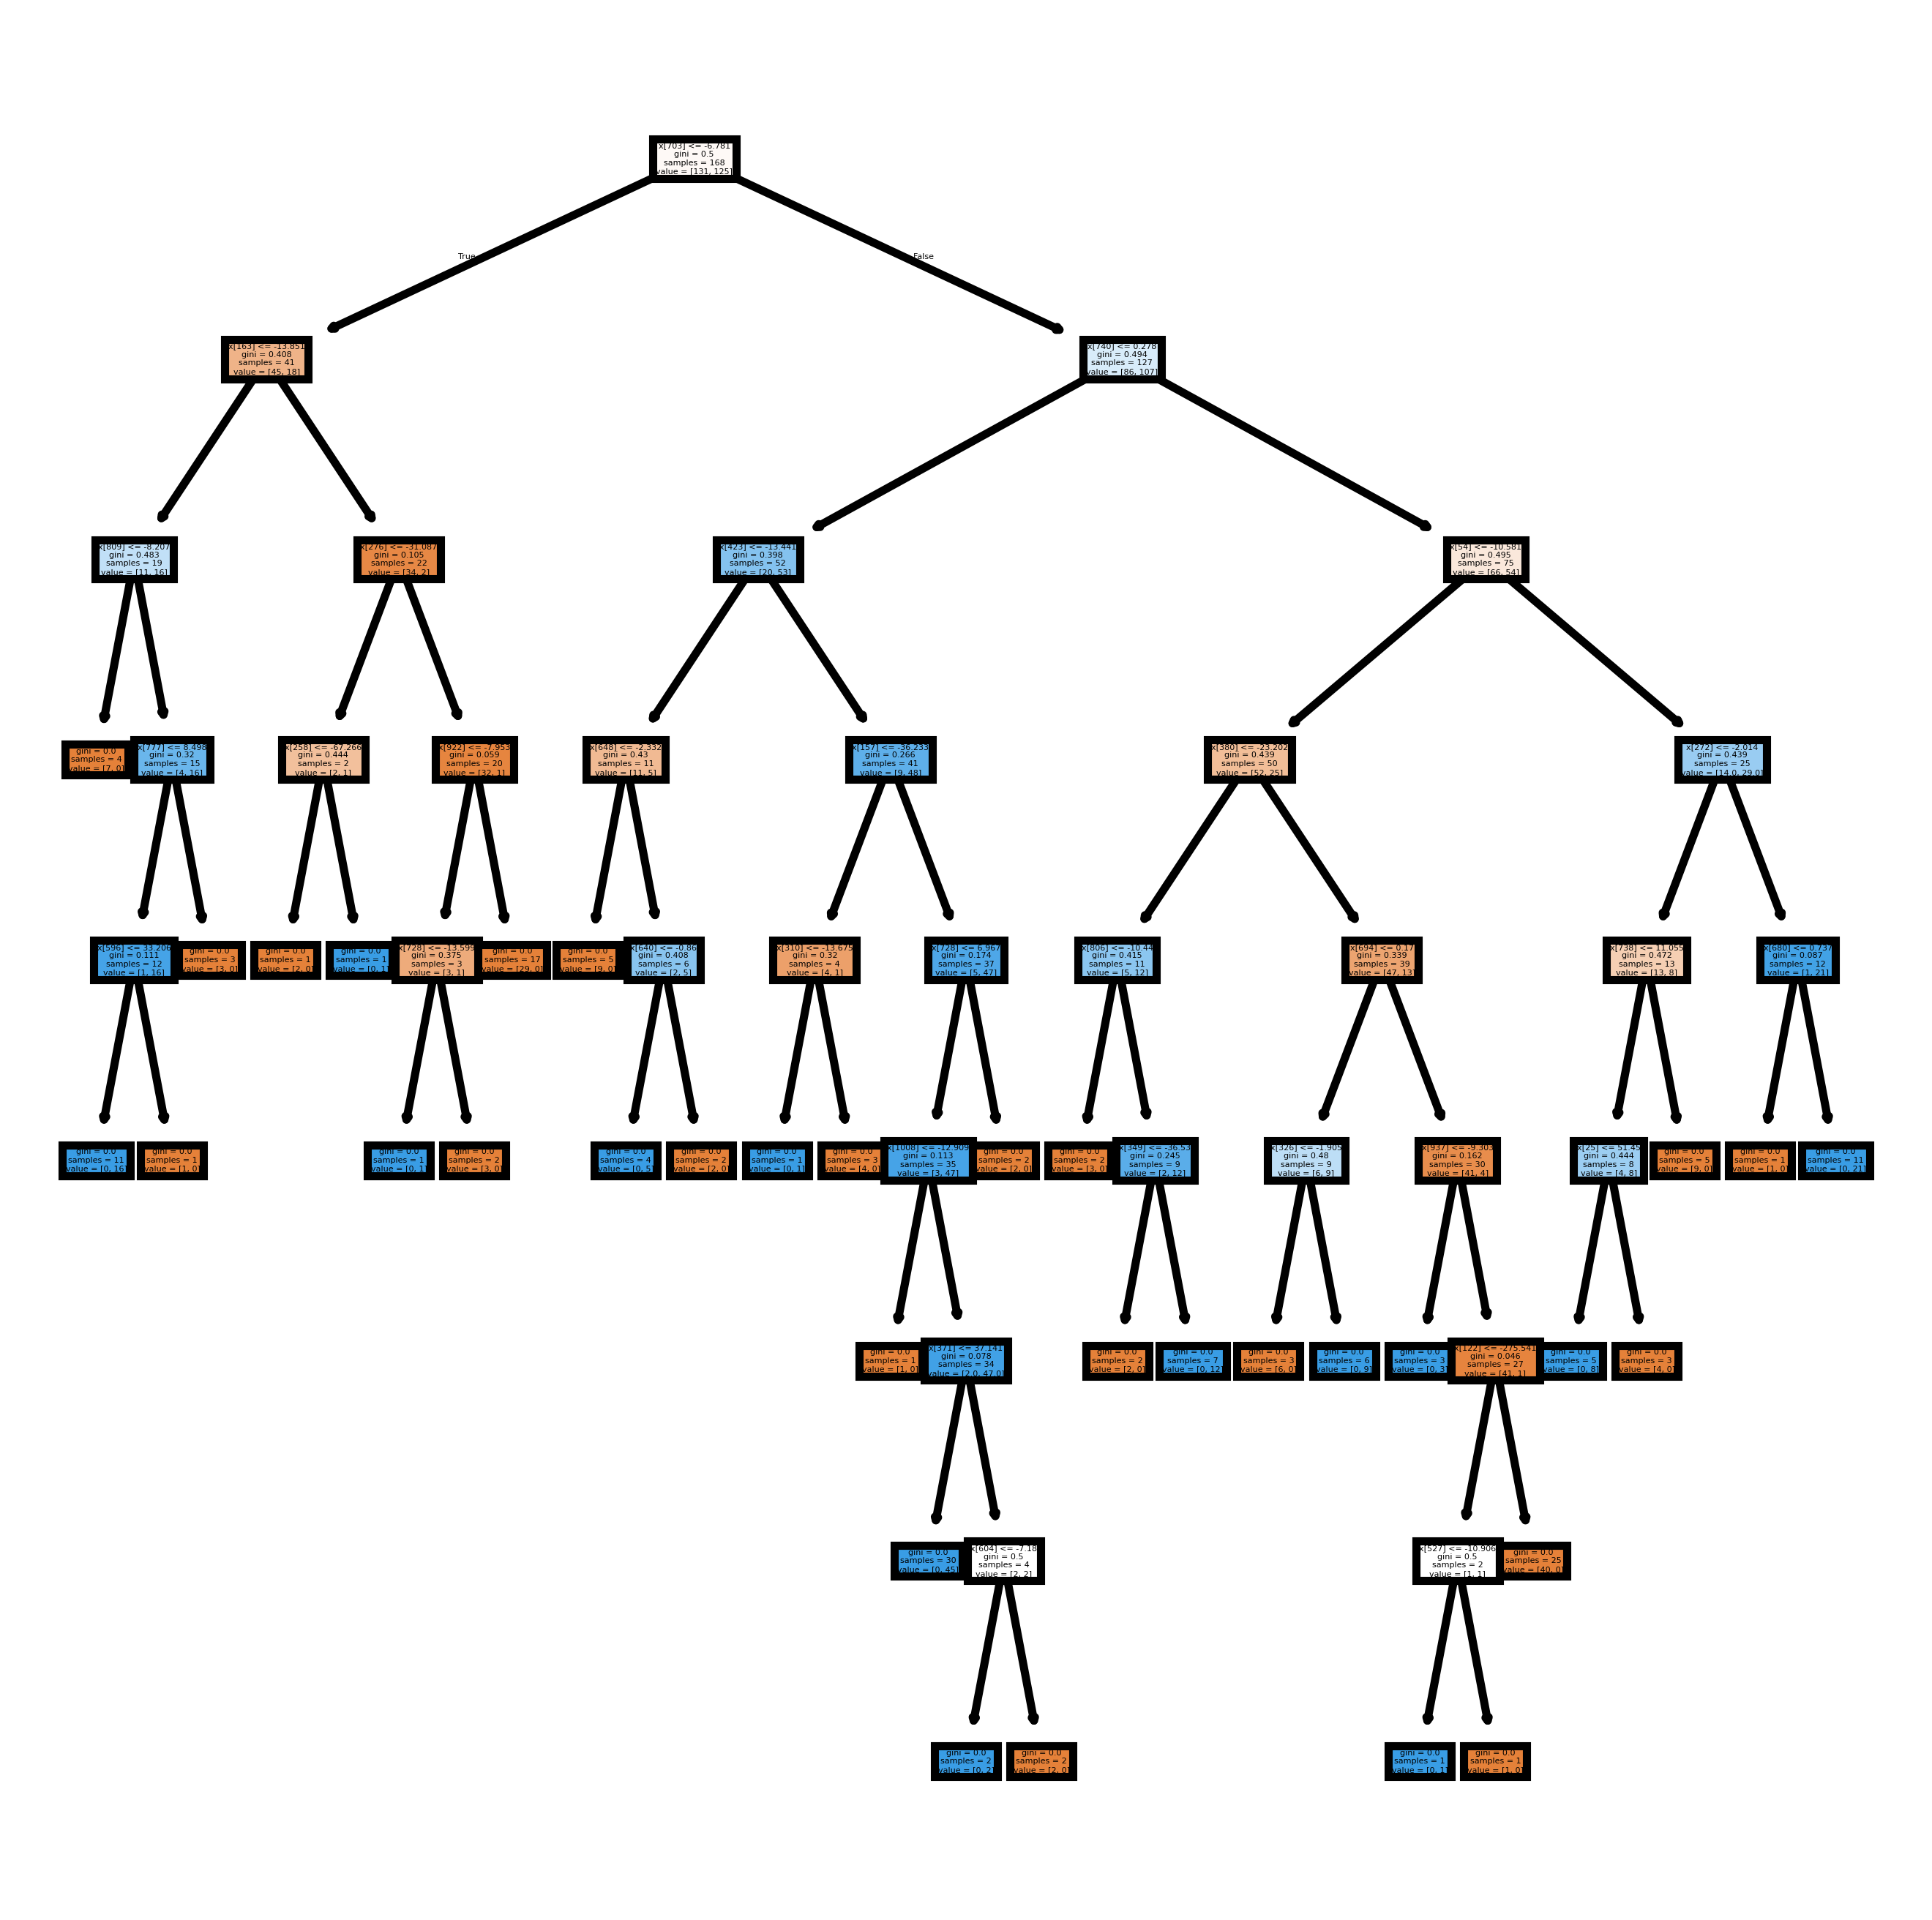

In [11]:
## TEMPORARY BEST MODEL

# Training
best_rf = RandomForestClassifier(max_depth=14, n_estimators=306, random_state=30)
best_rf.fit(X_train, y_train)

# test it
y_pred = best_rf.predict(X_test)

# Accuracy and Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cf_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Visualization
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(best_rf.estimators_[0],
               filled = True);
fig.savefig('rf_individualtree.png')

### Put the model in a pickle
import pickle

with open('my_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)



In [ ]:
new_rf = RandomForestClassifier()

new_rf.set_params(**rand_search.best_params_)

print(new_rf.get_params())

# test it
new_rf.fit(X_train, y_train)
y_pred = new_rf.predict(X_test)

# get the accuracy
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 493, 'n_jobs': None, 'oob_score': False, 'random_state': 46, 'verbose': 0, 'warm_start': False}
Confusion Matrix: 
 [[21 11]
 [13 19]]
Accuracy: 0.625
